In [1]:
from __future__ import division
%matplotlib inline
%pylab inline
import csv
import sys
import os
import traceback
import json
import pickle
import random
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
from scipy import stats
from scipy.signal import argrelextrema
import itertools
import scipy.fftpack as fft
from scipy.stats import norm, skew, kurtosis
from scipy.signal import butter, lfilter, filtfilt
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from collections import defaultdict, Counter, OrderedDict
from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval
from operator import itemgetter
from detect_peaks import detect_peaks
from gaussian_kde import gaussian_kde
import mean_shift as ms
import mean_shift_utils as ms_utils
import meta_features

Populating the interactive namespace from numpy and matplotlib


In [2]:
acc_axes = ['x','y','z']
mat_dir = '../data/multi_split'
sym_dir = os.path.join(mat_dir)#, 'symbolization')
files = [f.split('__')[1] for f in getListOfFiles(sym_dir, ".mat")]
print ">> {} mat Files found!".format(len(files))

>> 87 mat Files found!


In [3]:
dataset = OrderedDict()
previous_files = None

for ind, current_file in enumerate(files):
    file_data = {}
    for axis in acc_axes:
        ## load correspoding data structure
        mat_content = sio.loadmat(os.path.join(sym_dir, axis+'__'+current_file))
        data = mat_content['exp']
        val = data[0,0]

        ## grab the data
        ts = [x[0] for x in val['sig_data']]
        splitpoints = val['split_cand'][0].tolist()
        weights =  val['weights'][0].tolist()

        # structuring individual axis data
        file_data[axis+'.ts'] = ts
        file_data[axis+'.splits'] = splitpoints[:-1]
        file_data[axis+'.weights'] = weights[:-1]
    dataset[current_file] = file_data
print '>> {} files loaded'.format(len(dataset.keys()))

>> 29 files loaded


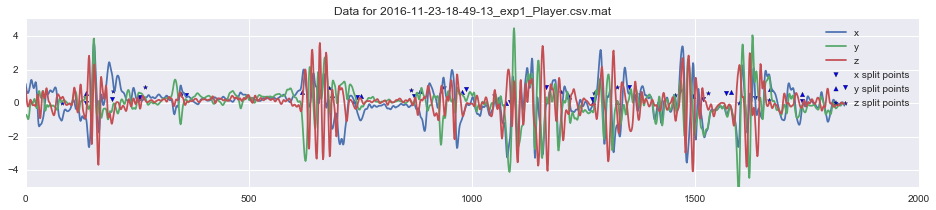

In [4]:
figsize(20,6)
file_number = 0
figsize(16,3)
markers = ['v', '^', '*']
for i,axis in enumerate(acc_axes):
    plt.plot(dataset[files[file_number]][axis+'.ts'], label= axis)
    y = np.random.rand(1,len(dataset[files[file_number]][axis+'.splits']))
    plt.scatter(dataset[files[file_number]][axis+'.splits'],y, marker=markers[i], label=axis+' split points')
plt.title('Data for ' + files[file_number])
plt.xlim(0,plt.xlim()[1])
plt.ylim(-5,5)
plt.legend()
plt.show()

## getting the separation points

In [ ]:
ma_mi_list = {}
cluster_centers = {}
tau = 1
for ind, current_file in enumerate(dataset.keys()):
    fig=figure(figsize=(15,8))
    ax1=fig.add_subplot(311)
    
    split_cand_list = []
    weigth_list = []
    data = dataset[current_file]
    for axis in acc_axes:
        split_cand_list += [(s,axis) for s in data[axis+'.splits']]
        weigth_list     += [(w,axis) for w in data[axis+'.weights']]

    weights = np.array([w[0] for w in weigth_list], np.float)
    samples = np.array([s[0] for s in split_cand_list])

    min, max = 0,len(data['x.ts'])
    x = np.linspace(min, max, max)

    clusters = []

    #Construct a KDE and plot it
    bws = [0.03]#0.01, 0.02, 0.03, 0.06, 0.1]
    ma = None
    mi = None
    for bw in bws:
        pdf = gaussian_kde(samples, bw_method=bw, weights=weights)
        y = pdf(x)
        ax1.plot(x, y, label='weighted kde, bw='+ str(bw))
        # mi = list of minimum indices in y.
        # ma = list of maximum indices in y.
        mi, ma = argrelextrema(y, np.less)[0], argrelextrema(y, np.greater)[0]
        #print "Minima:", x[mi]
        #print "Maxima:", x[ma]

        samples2 = []
        for s,w in zip(split_cand_list,weigth_list):
            samples2.append((s[0],w[0],s[1]))
        samples2 = np.array(samples2)

        for xc in x[mi]:
            ax1.axvline(x=xc, color='k', linestyle='-.')

        ## Get clusters by considering each one as a region between minimas. 
        # Count the itens for each cluster region. O(K), where K are regions defined by minimas.
        for m in range(len(mi)):
            if m == 0:
                clusters.append(samples2[samples < x[mi[m]]].tolist())
            else:
                clusters.append(samples2[(samples >= x[mi[m-1]]) * (samples <= x[mi[m]])].tolist())

        ax1.plot(x[ma], y[ma], 'g^',x[mi], y[mi], 'rv')

    ## Saving maxima e minima
    ma_mi_list[current_file] = {'mi': mi, 'ma': ma}
    
    energies = []
    total_energy = 0
    for ind,c in enumerate(clusters):
        accumulator = 0
        for elem in c:
            accumulator += float(elem[1])
        total_energy += accumulator
        energies.append((accumulator,ind))

    #energies = [(e/total_energy,ind) for inx,e in enumerate(energies)]

    #print 'Total energy: {}'.format(total_energy)
    #print 'Total energy after normalization: {}'.format(sum([e[0] for e in energies]))
    energies.sort(reverse=True, key=lambda tup: tup[0])

    #Plot the split candidates
    markers = ['o','x','^']
    colors = ['b', 'r','m']
    for i,axis in enumerate(acc_axes):
        ax1.scatter(data[axis+'.splits'], np.zeros_like(data[axis+'.splits']),
                    label='Split candidate for {}'.format(axis),
                    marker=markers[i], color='m')

    #Boiler plate
    plt.xticks([s[0] for s in split_cand_list],rotation = 90, fontsize=8)
    ax1.set_title('Split point gaussian kernel density estimation for {}'.format(current_file))
    ax1.set_xlabel('Variable')
    ax1.set_ylabel('Density')
    plt.legend(loc='best', frameon=False)

    final_clusters = []
    accumulator = 0
    for e in energies:
        accumulator += e[0]
        if accumulator > tau*total_energy:
            break
        else:
            final_clusters.append(e[1])

    #print 'Total: {}, Accumulator: {}, Threshold: {}'.format(total_energy,accumulator,tau*total_energy)
    cluster_centers[current_file] = x[ma[final_clusters]]

    ax2 = fig.add_subplot(312, sharex=ax1)
    ax2.plot(x, y, label='weighted kde, bw='+ str(bw))
    for xc in x[ma[final_clusters]]:
            ax2.axvline(x=xc, color='k', linestyle='-.')
    ax2.set_ylim(-0.0003,ax2.get_ylim()[1])
    plt.xticks([s[0] for s in split_cand_list],rotation = 90, fontsize=8)
    plt.legend(loc='best', frameon=False)

    ax3 = fig.add_subplot(313, sharex=ax1)
    for axis in acc_axes:
        ax3.plot(data[axis+'.ts'], label=axis)

    for xc in x[ma[final_clusters]]:
        ax3.axvline(x=xc, color='k', linestyle='-.')     

    plt.xticks(x[ma[final_clusters]],rotation = 90, fontsize=8)
    plt.legend(loc='best', frameon=False)
    plt.tight_layout()
    #plt.ylim(-0.0003,plt.ylim()[1])
    plt.xlim(min,max)
    plt.show()

## Getting the segments

In [ ]:
def get_segments(filename,maximas):
    data = dataset[filename]
    x_segments = []
    y_segments = []
    z_segments = []
    alignments = []
    
    min, max = 0,len(data['x.ts'])
    x = np.linspace(min, max, max)
    
    centers = [int(i) for i in sorted(cluster_centers[filename])]
    x_data = np.array(data['x.ts'])
    y_data = np.array(data['y.ts'])
    z_data = np.array(data['z.ts'])
    for i in range(len(centers)):
            if i == 0:
                x_segments.append(x_data[:int(centers[i])])
                y_segments.append(y_data[:int(centers[i])])   
                z_segments.append(z_data[:int(centers[i])])
                alignments.append(0)
            elif i == (len(centers)-1):
                x_segments.append(x_data[int(centers[i-1]):int(centers[i])].tolist())
                x_segments.append(x_data[int(centers[i]):].tolist())
                y_segments.append(y_data[int(centers[i-1]):int(centers[i])].tolist())
                y_segments.append(y_data[int(centers[i]):].tolist())
                z_segments.append(z_data[int(centers[i-1]):int(centers[i])].tolist())
                z_segments.append(z_data[int(centers[i]):].tolist())

                alignments.append(centers[i-1])
                alignments.append(centers[i])
            else:
                x_segments.append(x_data[int(centers[i-1]):int(centers[i])].tolist())
                y_segments.append(y_data[int(centers[i-1]):int(centers[i])].tolist())
                z_segments.append(z_data[int(centers[i-1]):int(centers[i])].tolist())
                alignments.append(centers[i-1])
    return x_segments, y_segments, z_segments, alignments

## Checking data segments equality with original time series.

In [ ]:
x_segments = []
y_segments = []
z_segments = []
alignments = []
file_map_list   = []

for f in dataset.keys():
    x_seg, y_seg, z_seg, aligns = get_segments(f,ma_mi_list[f]['ma'])
    ### testing equality
    try:
        assert list(itertools.chain.from_iterable(x_seg)) == dataset[f]['x.ts']
        assert list(itertools.chain.from_iterable(y_seg)) == dataset[f]['y.ts']
        assert list(itertools.chain.from_iterable(z_seg)) == dataset[f]['z.ts']
    except AssertionError:
        _, _, tb = sys.exc_info()
        traceback.print_tb(tb) # Fixed format
        tb_info = traceback.extract_tb(tb)
        filename, line, func, text = tb_info[-1]
        print('An error occurred on line {} in statement {}'.format(line, text))
        print('Equivalence test failed for file {}. ABORTING'.format(f))
        break
    
    for i in range(len(x_seg)):
        x_segments.append(x_seg[i])
        y_segments.append(y_seg[i])
        z_segments.append(z_seg[i])
        alignments.append(aligns[i])
        file_map_list.append('.'.join(f.split('.')[:-1]))
    
print 'ALL files PASSED on equivalence tests. This means the segmentation does not lose data!'

## Framming corpus

In [ ]:
df = {
      'x'    : x_segments,
      'y'    : y_segments,
      'z'    : z_segments,
      'align' : alignments,
      'file' : file_map_list
     }

frame = pd.DataFrame(df, index = [range(len(file_map_list))] , columns = ['x','y','z','align','file'])

## Exporting model to pickle.

In [ ]:
# open the file for writing
pkl_file_name = 'segments.pkl'
file_object = open(pkl_file_name,'wb')
pickle.dump(frame,file_object)
file_object.close()
print 'pickle DONE!'

## Plot by segment

In [ ]:
figure(figsize=(15,3))
filename = dataset.keys()[0]
for xc in cluster_centers[filename]:
    plt.axvline(x=xc, color='m', linestyle='-.')

x = list(itertools.chain.from_iterable(frame.loc[frame['file'] == '.'.join(filename.split('.')[:-1])]['x'].tolist()))
y = list(itertools.chain.from_iterable(frame.loc[frame['file'] == '.'.join(filename.split('.')[:-1])]['y'].tolist()))
z = list(itertools.chain.from_iterable(frame.loc[frame['file'] == '.'.join(filename.split('.')[:-1])]['z'].tolist()))
plt.plot(x,'-', label='x')
plt.plot(y, '-', label='y')
plt.plot(z, '-', label='z')
plt.title("Reconstructed file {}".format(filename))
plt.legend()
plt.xticks(cluster_centers[filename], rotation = 90)
#plt.ylim(-6,6)
plt.show()

____

## Bandwith selection

In [ ]:
ma_mi_list = {}
cluster_centers = {}
tau = 1#0.95
current_file = dataset.keys()[0]
fig=figure(figsize=(15,10))
ax1=fig.add_subplot(311)

split_cand_list = []
weigth_list = []
data = dataset[current_file]
for axis in acc_axes:
    split_cand_list += [(s,axis) for s in data[axis+'.splits']]
    weigth_list     += [(w,axis) for w in data[axis+'.weights']]

weights = np.array([w[0] for w in weigth_list], np.float)
samples = np.array([s[0] for s in split_cand_list])

min, max = 0,len(data['x.ts'])
x = np.linspace(min, max, max)

clusters = []

#Construct a KDE and plot it
bws = [0.03,0.01, 0.02, 0.03, 0.06]
for bw in bws:
    pdf = gaussian_kde(samples, bw_method=bw, weights=weights)
    y = pdf(x)
    ax1.plot(x, y, label='weighted kde, bw='+ str(bw))


#Plot the split candidates
markers = ['o','x','^']
colors = ['b', 'r','m']
for i,axis in enumerate(acc_axes):
    ax1.scatter(data[axis+'.splits'], np.zeros_like(data[axis+'.splits']),
                label='Split candidate for {}'.format(axis),
                marker=markers[i], color='m')

#Boiler plate
plt.xticks([s[0] for s in split_cand_list],rotation = 90, fontsize=8)
ax1.set_title('Split point gaussian kernel density estimation for {}'.format(current_file))
ax1.set_xlabel('Cutting point')
ax1.set_ylabel('Density')
plt.legend(loc='best', frameon=False)

ax3 = fig.add_subplot(312, sharex=ax1)
for axis in acc_axes:
    ax3.plot(data[axis+'.ts'], label=axis)   

plt.legend(loc='best', frameon=False)
plt.tight_layout()
ax1.set_xlabel('Acceleration')
ax1.set_ylabel('Cutting point')
plt.xlim(min,max)
plt.show()

# Loading pickle

In [5]:
resframe = []
with open("../pickle/annotation.pkl",'r') as f:
    resframe = pickle.load(f)
resframe.shape

(571, 6)

In [6]:
x_df = None
y_df = None
z_df = None
sup_resframe = resframe[resframe['tag'] !=""]
print 'Supervised dataset dim: {}'.format(sup_resframe.shape)
print 'Columns: {}'.format(sup_resframe.columns.tolist())
for df in sup_resframe.itertuples():
    x = pd.DataFrame({df[0]:df[1]})
    y = pd.DataFrame({df[0]:df[2]})
    z = pd.DataFrame({df[0]:df[3]})
    if df[0] == 0:
        x_df = x
        y_df = y
        z_df = z
    else:
        x_df = pd.concat([x_df,x], ignore_index=True, axis=1)
        y_df = pd.concat([y_df,y], ignore_index=True, axis=1)
        z_df = pd.concat([z_df,z], ignore_index=True, axis=1)
#x_df = pd.concat([x_df,sup_resframe.loc[:,'file':'tag']], ignore_index=True, axis=1)
#x_df.columns = x_df.columns[:-2].tolist() + ['file','tag']
#y_df = pd.concat([y_df,sup_resframe.loc[:,'file':'tag']], ignore_index=True, axis=1)
#y_df.columns = y_df.columns[:-2].tolist() + ['file','tag']
#z_df = pd.concat([z_df,sup_resframe.loc[:,'file':'tag']], ignore_index=True, axis=1)
#z_df.columns = z_df.columns[:-2].tolist() + ['file','tag']
print x_df.shape #all x's + file, tag
print y_df.shape #all y's + file, tag
print z_df.shape #all z's + file, tag


Supervised dataset dim: (286, 6)
Columns: ['x', 'y', 'z', 'align', 'file', 'tag']
(455, 286)
(455, 286)
(455, 286)


In [7]:
supervised = resframe[resframe['tag'] !=""]
print 'Supervised: {}'.format(supervised.shape)

Supervised: (286, 6)


In [8]:
unsupervised = resframe[resframe['tag'] ==""]
print 'Unsupervised: {}'.format(unsupervised.shape)

Unsupervised: (285, 6)


## Simbolization

In [9]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import segment
import fit

In [10]:
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

In [11]:
def get_angle(line_segment):
    angle = np.arctan2((line_segment[3]-line_segment[1]),line_segment[2]-line_segment[0])
    return angle

In [12]:
symmag_matrix = [['A','B','C','D','E','F'],
                 ['G','H','I','J','K','L'],
                 ['M','N','O','P','Q','R'],
                 ['S','T','U','V','W','X'],
                 ['Y','Z','1','2','3','4'],
                 ['5','6','7','8','9','10'],
                ]

symslope_matrix = [['A','B','C','D','E'],
                   ['F','G','H','I','J'],
                   ['K','L','M','N','O'],
                   ['P','Q','R','S','T'],
                   ['U','V','W','X','Y']]

def bin_slope(slope):
    if   slope <= 90 and slope > 60:
        return 5
    elif slope <= 60 and slope > 20:
        return 4
    elif slope <= 20 and slope >-20:
        return 3
    elif slope <=-20 and slope >-60:
        return 2
    elif slope <=-60 and slope >=-90:
        return 1
    
def bin_slopes(slopes):
    assig = []
    for slope in slopes:
        if   slope <= 90 and slope > 60:
            assig.append(4)
        elif slope <= 60 and slope > 20:
            assig.append(3)
        elif slope <= 20 and slope >-20:
            assig.append(2)
        elif slope <=-20 and slope >-60:
            assig.append(1)
        elif slope <=-60 and slope >=-90:
            assig.append(0)
    return assig

def bin_mags(mags):
    assig = []
    for mag in mags:
        if   mag >= 1 and mag < 2:
            assig.append(0)
        elif mag >= 2 and mag < 4:
            assig.append(1)
        elif mag >= 4 and mag < 6:
            assig.append(2)
        elif mag >= 6 and mag < 8:
            assig.append(3)
        elif mag >= 8 and mag < 10:
            assig.append(4)
        elif mag >= 10:
            assig.append(5)
    return assig

def mag_segment(slopes):
    mags = []
    for slope in slopes:
        mags.append(np.sqrt((slope[2]-slope[0])**2+(slope[3]-slope[1])**2))
    return mags

def simbolize_slopes(slopes):
    sym = []
    binned = bin_slopes(slopes)
    for i in range(1,len(slopes)):
        sym.append(symslope_matrix[binned[i-1]][binned[i]])
    return sym

def simbolize_mag(mag):
    sym = []
    binned = bin_mags(mag)
    for i in range(1,len(mag)):
        sym.append(symmag_matrix[binned[i-1]][binned[i]])
    return sym

def simbolize(slopes,mags):
    sym_sl = simbolize_slopes(slopes)
    sym_mag = simbolize_mag(mag)
    return [i+j for i,j in zip(sym_sl,sym_mag)]

In [35]:
### load data
#{u'High_level': u'Blocking-Dodging'} 30
#        {u'High_level': u'Inactive'} 7
#  {u'High_level': u'Locally-Moving'} 78
#         {u'High_level': u'Running'} 73
#       {u'High_level': u'Sprinting'} 27
#    {u'High_level': u'Stop-Running'} 36
#         {u'High_level': u'Walking'} 35

topics = ["{u'High_level': u'Blocking-Dodging'}",
          "{u'High_level': u'Inactive'}",
          "{u'High_level': u'Locally-Moving'}",
          "{u'High_level': u'Running'}",
          "{u'High_level': u'Sprinting'}",
          "{u'High_level': u'Stop-Running'}",
          "{u'High_level': u'Walking'}"]

topic = topics[2]

#define swab error
max_error = 0.0005
segs = []
mags = []
energies = []
means = []
smas = []

lengths = []
wrt = 'z'
#for topic in topics:
d_set = resframe[resframe['tag'] == topic][wrt].tolist()
for data in d_set:
    #swab with simple interpolation
    #fig = figure(figsize=(19,4))
    #ax=fig.add_subplot(131)
    #segments = segment.m_swab(data, fit.interpolate, fit.sumsquared_error, max_error)
    #draw_plot(data, "mSwab with simple interpolation for {} segment".format(topic.split("'")[-2]))
    #draw_segments(segments)
    #plt.figure()
    #plt.scatter([x[0] for x in segments],[x[1] for x in segments], marker='o', color='g')
    lengths.append(len(data))

    # get energies
    energies.append((meta_features.fft_energy(data, n_bins=200),topic))
    # get sma
    smas.append((meta_features.sma(data),topic))
    # get means
    means.append((meta_features.mean(data),topic))

    # get slopes
    #in_degrees = []
    #for seg in segments:
    #    in_degrees.append(np.rad2deg(get_angle(seg)))
    #segs += in_degrees

    # the histogram of the segment slopes
    #ax=fig.add_subplot(132)
    #n, bins, patches = plt.hist(in_degrees, 8, normed=1, facecolor='green', alpha=0.75)
    #ax.set_xlabel('degrees')
    #ax.set_ylabel('Probability')
    #ax.set_title('Slopes histogram')
    #ax.grid(True)

    # the histogram of the magnitudes data
    #ax=fig.add_subplot(133)
    #mag = mag_segment(segments)
    #mags += mag
    #n, bins, patches = plt.hist(mag, 8, normed=1, facecolor='green', alpha=0.75)
    #ax.set_xlabel('magnitudes')
    #ax.set_ylabel('Probability')
    #ax.set_title('Magnitude of slopes')
    #ax.grid(True)
    #plt.show()

    #### Print symbols
    #print 'Degrees: {}'.format(['{:.2f}'.format(x) for x in in_degrees])
    #print 'Magnitd: {}'.format(['{:.2f}'.format(m) for m in mag])
    #print 'Symbols: {}'.format(simbolize(in_degrees,mag))


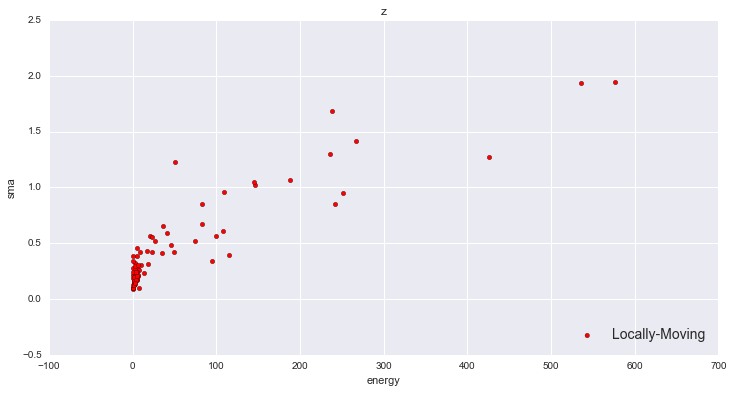

In [36]:
%matplotlib inline 
fst_var = 'energy'
snd_var = 'sma'

fig=figure(figsize=(12,6))
ax=fig.add_subplot(111)
only_energies = [z[0] for z in energies]
only_smas = [s[0] for s in smas]
only_means = [m[0] for m in means]
tgs = [s[1] for s in smas]
pd_ = pd.DataFrame([(e,s,t) for e,s,t in zip(only_energies,only_smas,tgs)], columns=['energy', "sma", 'tag'])
colors = ['r','g','b','m','c','m','y']
for i,t in enumerate(list(set(tgs))):
    ax.scatter(pd_.energy[pd_['tag'] ==t],pd_.sma[pd_['tag'] ==t], label=t.split("'")[-2], c=colors[i])
ax.legend(loc='lower right', frameon=False, fontsize=14)
ax.set_xlabel(fst_var)
ax.set_ylabel(snd_var)
ax.set_title(wrt)
plt.savefig(wrt+topic.split("'")[-2]+".png")
plt.show()

Using matplotlib backend: MacOSX


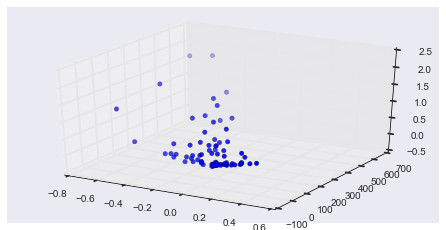

In [39]:
%matplotlib
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,3))
ax = Axes3D(fig)

ax.scatter(only_means,only_energies, only_smas)
plt.show()

## Visualizing the distribution

In [ ]:
# the histogram of the segment slopes
#data = (np.array(segs) - np.mean(segs))//np.std(segs)
fig=figure(figsize=(14,4))
ax=fig.add_subplot(131)
# Using the  Freedman-Diaconis rule for getting the number of bins
bin_size = 2 * meta_features.iqr(segs) * len(segs) ** (-1 / 3)
bins = int(round((max(segs) - min(segs)) / bin_size))
n, bins, patches = plt.hist(segs, bins, normed=1, facecolor='green', alpha=0.75, label='FDRuledBins')
ax.set_xlabel('degrees')
ax.set_ylabel('Probability')
ax.set_title('Angle of slopes {}-axis'.format(wrt))
ax.grid(True)
plt.legend()

# Fit a normal distribution to the data:
mu, sigma = norm.fit(segs)
# Plot the PDF.
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
ax.plot(x, p, 'k', linewidth=2, color='r', label='Fitted_pdf')
plt.legend()
print "Skewness= {}".format(meta_features.skewness(segs))

ax=fig.add_subplot(132)
# Using the  Freedman-Diaconis rule for getting the number of bins
bin_size = 2 * meta_features.iqr(mags) * len(mags) ** (-1 / 3)
bins = int(round((max(mags) - min(mags)) / bin_size))
n, bins, patches = plt.hist(mags, 8, normed=1, facecolor='green', alpha=0.75, label='8 Bins')
ax.set_xlabel('magnitude')
ax.set_ylabel('Probability')
ax.set_title('Slopes magnitudes {}-axis'.format(wrt))
ax.grid(True)
plt.legend()

ax=fig.add_subplot(133)
# Using the  Freedman-Diaconis rule for getting the number of bins
ax.scatter(segs,mags)
ax.set_xlabel('degrees')
ax.set_ylabel('magnitudes')
ax.set_title('Cross plot {}-axis'.format(wrt))
ax.grid(True)
plt.savefig('{}_{}_mSWABError={}.png'.format(wrt,topic.split("'")[-2],max_error))

## Perform the Hierarchical Clustering

#### Loading the corresponding data

In [ ]:
#{u'High_level': u'Blocking-Dodging'} 30
#        {u'High_level': u'Inactive'} 7
#  {u'High_level': u'Locally-Moving'} 78
#         {u'High_level': u'Running'} 73
#       {u'High_level': u'Sprinting'} 27
#    {u'High_level': u'Stop-Running'} 36
#         {u'High_level': u'Walking'} 35


topic = "{u'High_level': u'Walking'}"
x_sig_segments = sup_resframe[sup_resframe['tag']== topic]['x'].tolist()
y_sig_segments = sup_resframe[sup_resframe['tag']== topic]['y'].tolist()
z_sig_segments = sup_resframe[sup_resframe['tag']== topic]['z'].tolist()
print np.array(x_sig_segments).shape
print np.array(y_sig_segments).shape
print np.array(z_sig_segments).shape

#### loading metafeatures dispatcher

In [ ]:
function_dispatcher = {
    "mean"     : meta_features.mean,
    "std"      : meta_features.std,
    "max"      : meta_features.max_value,
    "min"      : meta_features.min_value,
    "mad"      : meta_features.mad,
    "sma"      : meta_features.sma,
    "iqr"      : meta_features.iqr,
    "energy"   : meta_features.energy,
    "maxInds"  : meta_features.maxInds,
    "meanFreq" : meta_features.meanFreq,
    "skewness" : meta_features.skewness,
    "kurtosis" : meta_features.kurtos,
    "freq_skewness" : meta_features.freq_skewness,
    "freq_kurtosis" : meta_features.freq_kurtos,
    "num_peaks"     : meta_features.num_peaks,
    "moving_rmsV1"  : meta_features.moving_rmsV1,
    "rms"           : meta_features.rms,
    "max_min"       : meta_features.max_min
}

In [ ]:
def get_metafeat_vector(segment, mf=["mean","std","max","min","mad","sma",
                                        "iqr","energy","maxInds","meanFreq","skewness","kurtosis"]):
    """
        Compute metafeatures from segment data.
    
        segment : the time series segment
        mf      : list of metafeatures functions to be computed on the segment data.
    """
    
    meta_vector = OrderedDict()

    for f in mf:
        try:
            func = function_dispatcher[f]          # retrieve function
            meta_vector[f] = func(segment)    # compute function on segment.
        except KeyError:
            raise ValueError('Invalid function: {}'.format(f))

    return meta_vector

#### Computing metafeatures

In [ ]:
## metafeatures list to be computed
#to_compute = ["mean","std","max","min","mad","sma","iqr","rms","maxInds","skewness","kurtosis","freq_skewness","freq_kurtosis"]
#to_compute = ["mean","std","mad","sma","iqr","skewness","kurtosis","maxInds","rms","num_peaks"]
to_compute = ["num_peaks", "rms"]
x_meta_vectors = []
y_meta_vectors = []
z_meta_vectors = []

#### CALCULATE A CORRELATION ###
correlationxy =[]
correlationxz =[]
correlationyz =[]

lengths = []

for s in range(len(z_sig_segments)):
    correlationxy.append(meta_features.correlation(x_sig_segments[s], y_sig_segments[s]))
    correlationxz.append(meta_features.correlation(x_sig_segments[s], z_sig_segments[s]))
    correlationyz.append(meta_features.correlation(y_sig_segments[s], z_sig_segments[s]))
    lengths.append(len(z_sig_segments[s]))
    
for s in x_sig_segments:
    x_meta_vectors.append(get_metafeat_vector(s, mf=to_compute).values())
for s in y_sig_segments:
    y_meta_vectors.append(get_metafeat_vector(s, mf=to_compute).values())
for s in z_sig_segments:
    z_meta_vectors.append(get_metafeat_vector(s, mf=to_compute).values())
    
X = np.array(x_meta_vectors)
Y = np.array(y_meta_vectors)
Z = np.array(z_meta_vectors)
print X.shape

### Performing clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Zx = None
Zy = None
Zz = None
# Check the Cophenetic Correlation Coefficient of the clustering 
# with help of the cophenet() function. This (very very briefly)
# compares (correlates) the actual pairwise distances of all samples 
# to those implied by the hierarchical clustering. The closer the value
# is to 1, the better the clustering preserves the original distances.
for t in ['ward','single', 'complete', 'average']:
    # generate the linkage matrix
    Zx = linkage(X, t)
    c, coph_dists = cophenet(Zx, pdist(X))#, 'cosine'))
    print 'Linkage {} has a Cophenetic Correlation Coefficient of {}'.format(t,c)
Zx = linkage(X,'average')

for t in ['ward','single', 'complete', 'average']:
    # generate the linkage matrix
    Zy = linkage(Y, t)
    c, coph_dists = cophenet(Zy, pdist(Y))#, 'cosine'))
    print 'Linkage {} has a Cophenetic Correlation Coefficient of {}'.format(t,c)
Zy = linkage(Y,'average')

for t in ['ward','single', 'complete', 'average']:
    # generate the linkage matrix
    Zz = linkage(Z, t)
    c, coph_dists = cophenet(Zz, pdist(Z))#, 'cosine'))
    print 'Linkage {} has a Cophenetic Correlation Coefficient of {}'.format(t,c)
Zz = linkage(Z,'average')

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    title = kwargs.pop('title',None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title(title)
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
z_map = {'x':Zx,'y':Zy,'z':Zz}
for ax in ['x','y','z']:
    figure()
    plot_title = 'Hierarchical Clustering Dendrogram ({}) - {}_axis -- Feat:{}'.format(topic.split("'")[-2],ax,to_compute)
    fancy_dendrogram(
        z_map[ax],
        title=plot_title,
        truncate_mode='lastp',
        p=12,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
        annotate_above=10,  # useful in small plots so annotations don't overlap
    )
    plt.savefig(plot_title+'.png')

In [ ]:
from scipy.cluster.hierarchy import fcluster
x_max_d = 2
clustersx = fcluster(Zx, x_max_d, criterion='distance')
print Counter(clustersx)

y_max_d = 2
clustersy = fcluster(Zy, y_max_d, criterion='distance')
print Counter(clustersy)

z_max_d = 2
clustersz = fcluster(Zz, z_max_d, criterion='distance')
print Counter(clustersz)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig=figure(figsize=(14,4))
ax=fig.add_subplot(131)
#ax = Axes3D(fig)
ax.scatter(X[:,0].tolist(), X[:,1].tolist(), c=clustersx, cmap='prism')  # plot points with cluster dependent colors
ax.set_title('{} - x_axis -- {} - CT-{}'.format(topic.split("'")[-2], to_compute,x_max_d))
ax.set_xlabel("num_peaks")
ax.set_ylabel("rms")

ax=fig.add_subplot(132)
ax.scatter(Y[:,0].tolist(), Y[:,1].tolist(), c=clustersy, cmap='prism')  # plot points with cluster dependent colors
ax.set_title('{} - y_axis -- {} - CT-{}'.format(topic.split("'")[-2], to_compute,y_max_d))
ax.set_xlabel("num_peaks")
ax.set_ylabel("rms")

ax=fig.add_subplot(133)
ax.scatter(Z[:,0].tolist(), Z[:,1].tolist(), c=clustersz, cmap='prism')  # plot points with cluster dependent colors
ax.set_title('{} - z_axis -- {} - CT-{}'.format(topic.split("'")[-2], to_compute,z_max_d))
ax.set_xlabel("num_peaks")
ax.set_ylabel("rms")

plt.savefig("2DPlot for {} -- {}".format(topic.split("'")[-2],to_compute))
plt.show()